## *Step 1: Import Modules*

In [1]:
!pip3 install graphviz
!pip3 install ann_visualizer


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import numpy as np
import pandas as pd
import os
from glob import glob
import itertools
import fnmatch
import random

import matplotlib.pylab as plt
import seaborn as sns
import cv2
from PIL import Image
from ann_visualizer.visualize import ann_viz

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import tensorflow.compat.v1 as tf
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

%matplotlib inline


In [31]:
# !pip install tensorflow
!pip install ann_visualizer


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install opencv-python


     ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/38.6 MB ? eta


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     -- ------------------------------------- 2.1/38.6 MB 13.3 kB/s eta 0:45:40
     -- ------------------------------------- 2.1/38.6 MB 13.3 kB/s eta 0:45:40
     -- ------------------------------------- 2.1/38.6 MB 13.3 kB/s eta 0:45:40
     -- ------------------------------------- 2.1/38.6 MB 13.3 kB/s eta 0:45:40
     -- ------------------------------------- 2.1/38.6 MB 13.3 kB/s eta 0:45:40
     -- ------------------------------------- 2.1/38.6 MB 13.3 kB/s eta 0:45:40
     -- ------------------------------------- 2.1/38.6 MB 13.3 kB/s eta 0:45:40
     -- ------------------------------------- 2.1/38.6 MB 13.3 kB/s eta 0:45:40
     -- ------------------------------------- 2.1/38.6 MB 13.3 kB/s eta 0:45:40
     -- ------------------------------------- 2.1/38.6 MB 13.3 kB/s eta 0:45:40
     -- ------------------------------------- 2.1/38.6 MB 13.3 kB/s eta 0:45:40
     -- ------------------------------------- 2.1/38.6 MB 13.3 kB/s eta 0:45:40
     -- --------------------------------

## *Step 2: Explore Data*

In [16]:
# Adding path of all the images together 
imagePatches = glob('Dataset/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

Dataset\10253\0\10253_idx5_x1001_y1001_class0.png
Dataset\10253\0\10253_idx5_x1001_y1051_class0.png
Dataset\10253\0\10253_idx5_x1001_y1101_class0.png
Dataset\10253\0\10253_idx5_x1001_y1151_class0.png
Dataset\10253\0\10253_idx5_x1001_y1201_class0.png
Dataset\10253\0\10253_idx5_x1001_y1251_class0.png
Dataset\10253\0\10253_idx5_x1001_y1301_class0.png
Dataset\10253\0\10253_idx5_x1001_y1351_class0.png
Dataset\10253\0\10253_idx5_x1001_y1501_class0.png
Dataset\10253\0\10253_idx5_x1001_y1551_class0.png


(-0.5, 49.5, 49.5, -0.5)

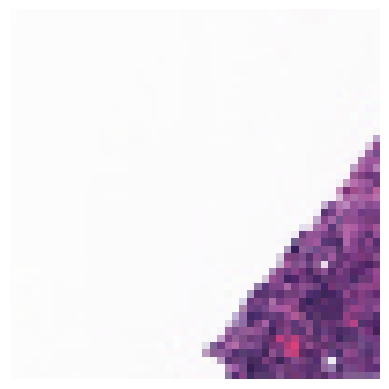

In [17]:
image_sample = "Dataset/10253/1/10253_idx5_x501_y351_class1.png"
dsize=(50,50)

image = cv2.imread(image_sample)
image = cv2.resize(image, dsize)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')


## *Step 3: Preprocess Data*

In [18]:

resized_images, labels_arr = [], []
dsize = (50, 50)

for img in imagePatches[0:20000]:
    if os.path.exists(img):  # Check if the file exists
        full_size_image = cv2.imread(img)
        if full_size_image is not None:  # Check if the image was read successfully
            cv2.imshow('image', full_size_image)
            resized_images.append(cv2.resize(full_size_image, dsize, interpolation=cv2.INTER_CUBIC))
            labels_arr.append(int(img[-5]))


In [19]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(len(a)-np.sum(b)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(resized_images,labels_arr)

Total number of images: 9506
Number of IDC(-) Images: 7254
Number of IDC(+) Images: 2252
Image shape (Width, Height, Channels): (50, 50, 3)


- The data is scaled from 0 to 256 but we want it to be scaled from 0 to 1.
- We also want to set aside 20% of the data for testing.
- And finally, we will use an undersampling strategy to deal with the imbalanced class sizes.

In [20]:
X=np.array(resized_images)
Y=pd.Series(labels_arr) 
X=X/255.0
 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, )

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (7604, 50, 50, 3)
Testing Data Shape: (1902, 50, 50, 3)


<Axes: title={'center': 'Distribution of target classes'}, ylabel='count'>

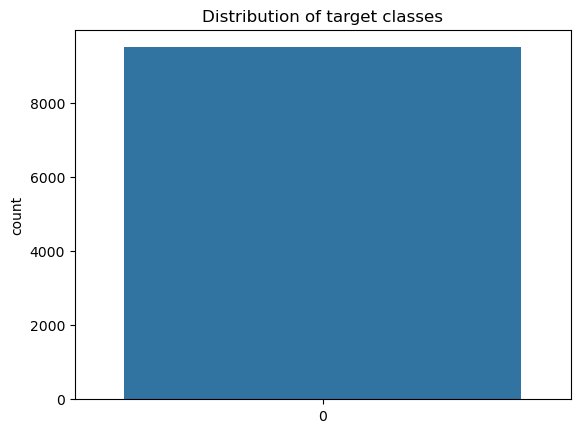

In [21]:
plt.title("Distribution of target classes")
sns.countplot(Y) 

In [22]:
# Make Data 1D for compatability upsampling methods
image_shape = 50*50*3

X_train = X_train.reshape(X_train.shape[0], image_shape)
X_test = X_test.reshape(X_test.shape[0], image_shape)


In [23]:
print("Shape of flattened training data:",X_train.shape,"\nShape of flatened testing data: ",X_test.shape)

Shape of flattened training data: (7604, 7500) 
Shape of flatened testing data:  (1902, 7500)


In [3]:
!pip show imbalanced-learn


Name: imbalanced-learn
Version: 0.11.0
Summary: Toolbox for imbalanced dataset in machine learning.
Home-page: https://github.com/scikit-learn-contrib/imbalanced-learn
Author: 
Author-email: 
License: MIT
Location: C:\Users\ELCOT\anaconda3\Lib\site-packages
Requires: joblib, numpy, scikit-learn, scipy, threadpoolctl
Required-by: 


In [24]:
# Deal with imbalanced class sizes below

# from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler

# Ros = RandomOverSampler(sampling_strategy='auto') 
Rus = RandomUnderSampler(sampling_strategy='auto')

X_trainRusFlat, Y_trainRus = Rus.fit_resample(X_train, Y_train)
X_testRusFlat, Y_testRus = Rus.fit_resample(X_test, Y_test)

#Reshape the images
X_trainRus = X_trainRusFlat.reshape(len(X_trainRusFlat),50,50,3)
X_testRus = X_testRusFlat.reshape(len(X_testRusFlat),50,50,3)

# Encode labels
Y_trainRus = to_categorical(Y_trainRus, num_classes = 2)
Y_testRus = to_categorical(Y_testRus, num_classes = 2)


In [25]:
print("New shape of Train data =",X_trainRus.shape)
print("New shape of Test data =",X_testRus.shape)

New shape of Train data = (3664, 50, 50, 3)
New shape of Test data = (840, 50, 50, 3)


## *Step 4: Define Helper Functions for the Classification Task*

In [26]:
# Helper Functions  Learning Curves and Confusion Matrix 

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotLearningCurve():
    
    plt.figure(figsize=(10,6))
    metrics = np.load('logs.npy', allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')
    
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_learning_curve(history):
    
    plt.figure(figsize=(10,6))
    
    #model accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # model loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
def plot_confusion_matrix(cm, normalize=False, cmap=plt.cm.Blues):
    title='Confusion matrix'
    classes = {0: 'IDC(-)', 1: 'IDC(+)'}
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## *Step 5: Evaluate Classification Models*

In [15]:
def build_ANN(num_classes=2,input_shape = (50,50, 3)):
#     input_shape=(7500,)
    model=Sequential()
    model.add(Flatten(input_shape=input_shape))
    
    #first layer with 500 neurons and relu activation function 
    model.add(Dense(100, activation="relu"))
    
    #second layer with 500 neurons and relu activation function 
    model.add(Dense(100, activation="relu"))
    
    #third layer with 500 neurons and relu activation function 
    model.add(Dense(100, activation="relu"))
    
    #fourth layer with 500 neurons and relu activation function 
    model.add(Dense(100, activation="relu"))
    
    #fifth layer with 500 neurons and relu activation function 
    model.add(Dense(100, activation="relu"))
    
    #output sigmoid layer 
    model.add(Dense(num_classes, activation="sigmoid"))
        
    return model

In [27]:
def build_base_CNN(num_classes=2, input_shape = (50,50, 3)):
        
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(32, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='sigmoid'))
    
    return model

In [17]:
def build_final_CNN(num_classes=2, input_shape = (50,50, 3)):
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3))) 
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid')) # output 1 value between 0 and 1 : probability to have cancer
      
    return model

In [28]:
def eval_model(model, a, b, c, d, model_name=None, Visualize=False):
    
    
    batch_size = 32
    epochs = 25
    
    model.compile(loss="binary_crossentropy", # Use binary crossentropy as a loss function  
                  optimizer="adam",
                  metrics=['accuracy'])
    
    model.summary()
    if Visualize:
        print("Visualizing your neural network.")
        ann_viz(model, title=model_name, filename=model_name)
    
    history = model.fit(a,b,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data = (c,d),
            callbacks = [MetricsCheckpoint('logs')])
    
    if model_name:
        model.save(model_name+".h5")
    
    score = model.evaluate(c,d, verbose=0)
    print('\n accuracy:', score[1],'\n')
    
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    
    print('\n', classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    
    Y_true = np.argmax(d,axis=1) 
    
    plotLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx) 
    plt.show()

In [29]:
import numpy as np

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 7500)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               750100    
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_11 (Dense)            (None, 2)                

C:\Users\ELCOT\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



 accuracy: 0.8598654866218567 

28/28 [==============================] - 5s 7ms/step

              precision    recall  f1-score   support

      IDC(-)       0.84      0.89      0.86       446
      IDC(+)       0.88      0.83      0.86       446

    accuracy                           0.86       892
   macro avg       0.86      0.86      0.86       892
weighted avg       0.86      0.86      0.86       892



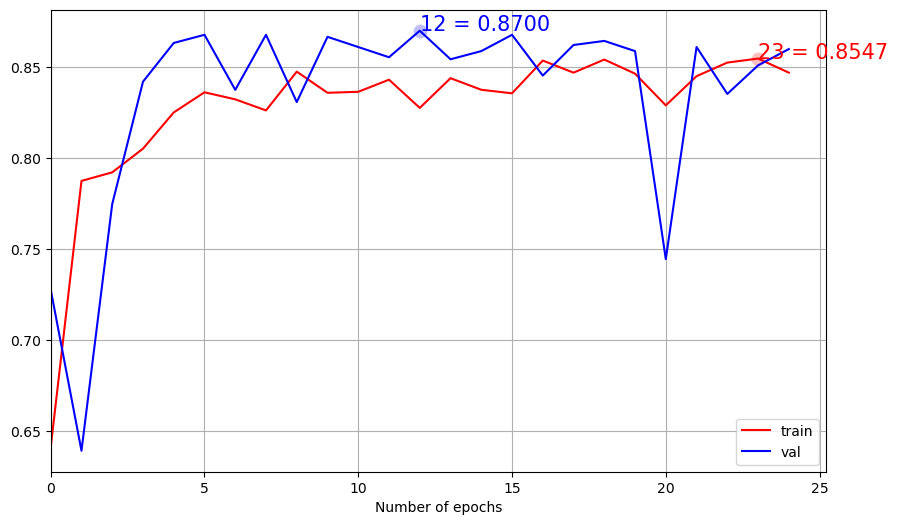

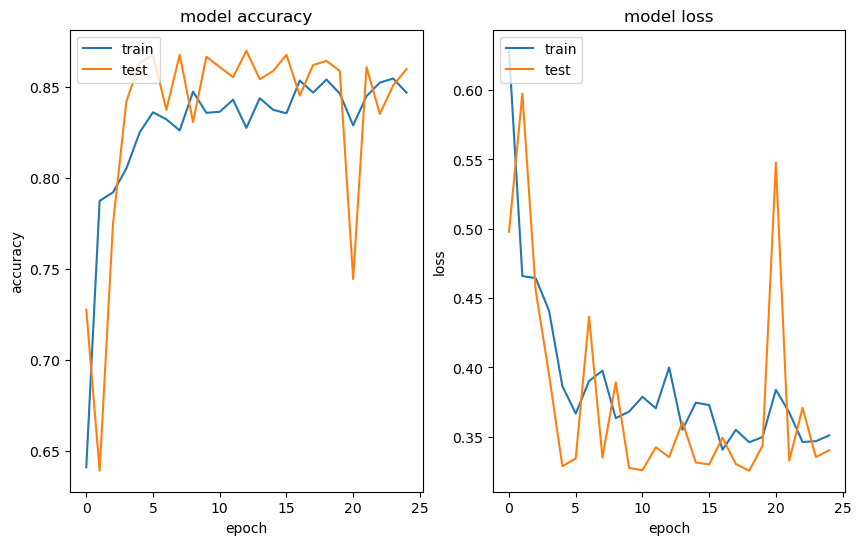

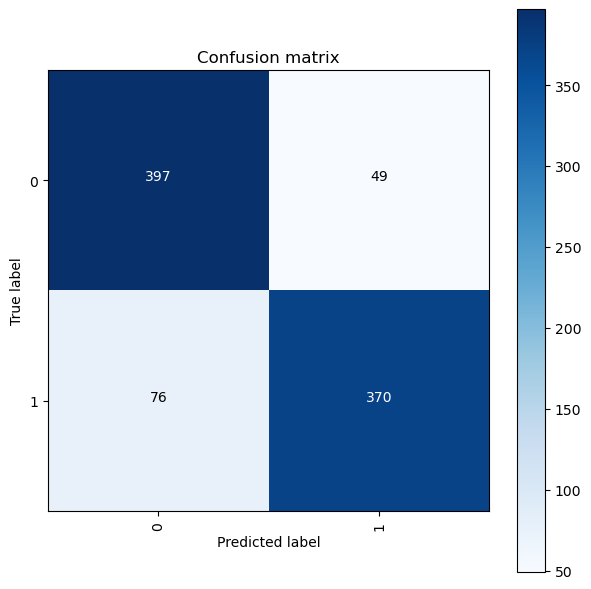

In [21]:
X_train_reshaped = X_trainRusFlat.reshape(-1, 50, 50, 3)
X_test_reshaped = X_testRusFlat.reshape(-1, 50, 50, 3)

eval_model(build_ANN(), X_train_reshaped, Y_trainRus, X_test_reshaped, Y_testRus, 'ANN')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        2432      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 23, 23, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 19, 19, 32)        25632     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 9, 9, 32)          0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 9, 9, 32)         

C:\Users\ELCOT\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



 accuracy: 0.8559523820877075 

27/27 [==============================] - 2s 47ms/step

              precision    recall  f1-score   support

      IDC(-)       0.86      0.85      0.85       420
      IDC(+)       0.85      0.87      0.86       420

    accuracy                           0.86       840
   macro avg       0.86      0.86      0.86       840
weighted avg       0.86      0.86      0.86       840



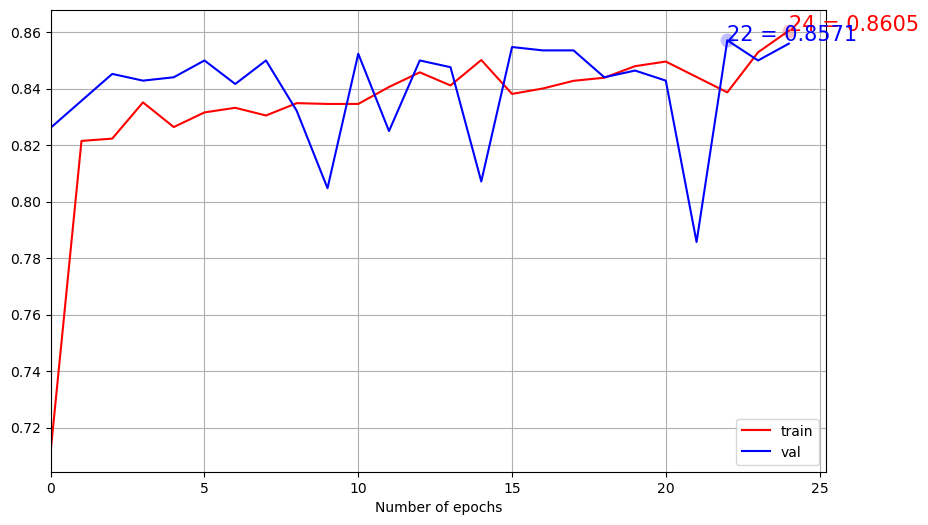

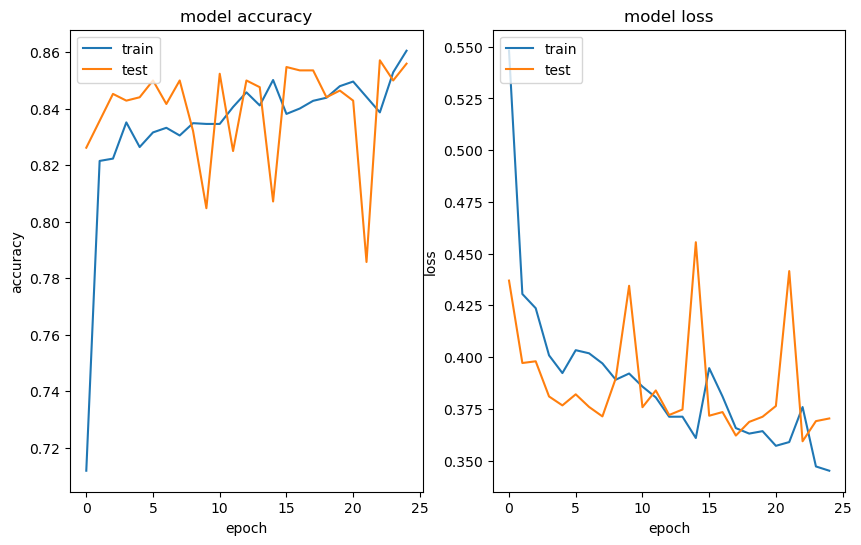

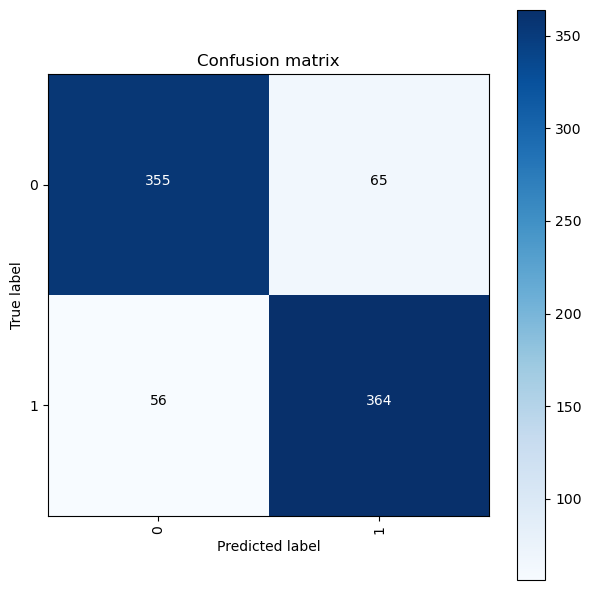

In [32]:
# eval_model(build_base_CNN(),X_trainRus, Y_trainRus, X_testRus, Y_testRus, 'base_CNN', True)

from tensorflow import keras  # Import keras from tensorflow

batch_size = 32
epochs = 25
model=build_base_CNN()
a=X_trainRus
b=Y_trainRus
c=X_testRus
d=Y_testRus
model_name="base_CNN"
    
model.compile(loss="binary_crossentropy", # Use binary crossentropy as a loss function  
                  optimizer="adam",
                  metrics=['accuracy'])
    
model.summary()
history = model.fit(a,b,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data = (c,d),
            callbacks = [MetricsCheckpoint('logs')])
    
if model_name:
    model.save(model_name+".h5")
    
score = model.evaluate(c,d, verbose=0)
print('\n accuracy:', score[1],'\n')
    
y_pred = model.predict(c)
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

print('\n', classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
Y_pred_classes = np.argmax(y_pred,axis=1)     

Y_true = np.argmax(d,axis=1) 
    
plotLearningCurve()
plt.show()  
plot_learning_curve(history)
plt.show()
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx) 
plt.show()

In [40]:
!pip install --upgrade keras tensorflow

  Using cached keras-3.0.4-py3-none-any.whl (1.0 MB)
  Using cached rich-13.7.0-py3-none-any.whl (240 kB)
  Using cached namex-0.0.7-py3-none-any.whl (5.8 kB)
  Using cached dm_tree-0.1.8-cp311-cp311-win_amd64.whl (101 kB)



[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
pip install --upgrade ann_visualizer

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_48 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 4, 4, 64)          0         
 ng2D)                                                           
                                                                 
 dropout_49 (Dropout)        (None, 4, 4, 64)        

C:\Users\ELCOT\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



 accuracy: 0.8665919303894043 

28/28 [==============================] - 3s 74ms/step

              precision    recall  f1-score   support

      IDC(-)       0.83      0.92      0.87       446
      IDC(+)       0.91      0.81      0.86       446

    accuracy                           0.87       892
   macro avg       0.87      0.87      0.87       892
weighted avg       0.87      0.87      0.87       892



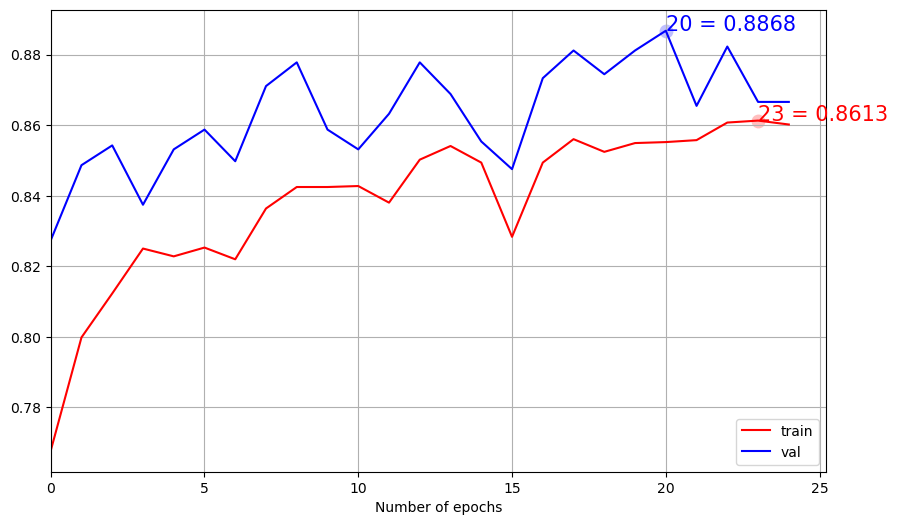

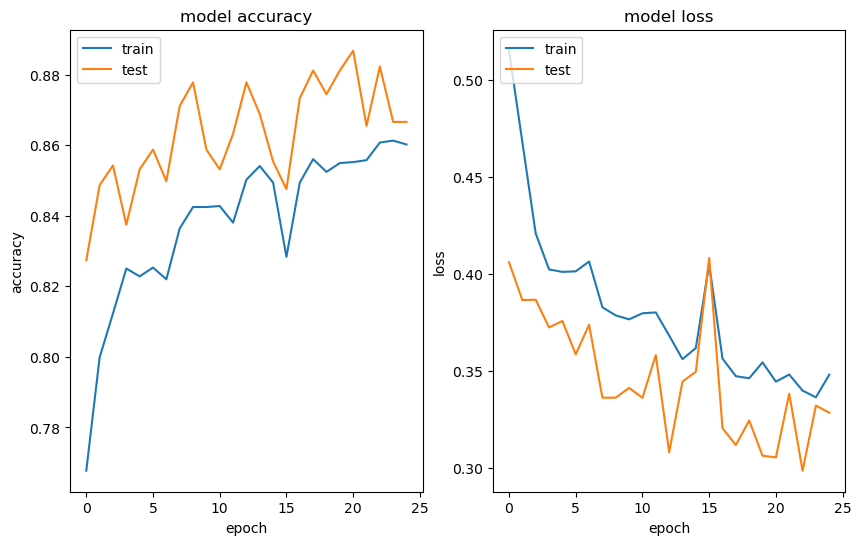

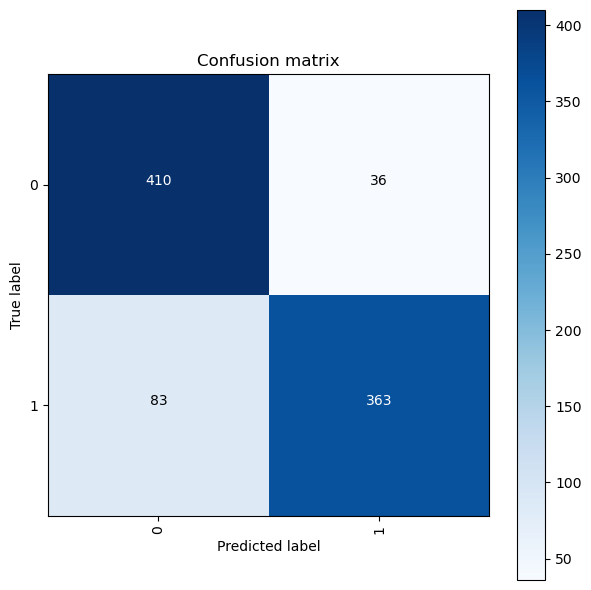

In [47]:
from tensorflow import keras  # Import keras from tensorflow

# eval_model(build_final_CNN(),X_trainRus, Y_trainRus, X_testRus, Y_testRus, 'final_CNN', True)
batch_size = 32
epochs = 25
model=build_final_CNN()
a=X_trainRus
b=Y_trainRus
c=X_testRus
d=Y_testRus
model_name="final_CNN"
    
model.compile(loss="binary_crossentropy", # Use binary crossentropy as a loss function  
                  optimizer="adam",
                  metrics=['accuracy'])
    
model.summary()
history = model.fit(a,b,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data = (c,d),
            callbacks = [MetricsCheckpoint('logs')])
    
if model_name:
    model.save(model_name+".h5")
    
score = model.evaluate(c,d, verbose=0)
print('\n accuracy:', score[1],'\n')
    
y_pred = model.predict(c)
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

print('\n', classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
Y_pred_classes = np.argmax(y_pred,axis=1)     

Y_true = np.argmax(d,axis=1) 
    
plotLearningCurve()
plt.show()  
plot_learning_curve(history)
plt.show()
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx) 
plt.show()

In [33]:
from tensorflow.keras.models import load_model
annmodel = load_model('ANN.h5')
base_cnnmodel = load_model('base_CNN.h5')
final_cnnmodel = load_model('final_CNN.h5')

In [34]:
#function to plot image
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])
    

## Test Case 1

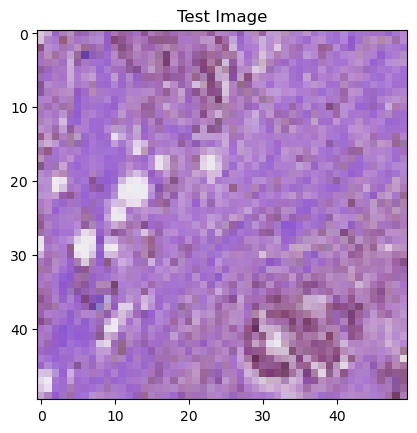

In [35]:
index1 = 51
img_plot(X_testRus, index1)

In [36]:
input1 = X_testRus[index1:index1+1]
print('Input Index =',index1)


Input Index = 51


In [37]:
label1 = Y_testRus[index1].argmax()
annpred1 = annmodel.predict(input1)[0].argmax()
base_cnnpred1 = base_cnnmodel.predict(input1)[0].argmax()
final_cnnpred1 = final_cnnmodel.predict(input1)[0].argmax()

print('Predicted Value using ann model',annpred1)
print('Predicted Value using base cnn model',base_cnnpred1)
print('Predicted Value using final cnn model',final_cnnpred1)

print("\nTrue Value",label1)

1/1 [==============================] - 0s 254ms/step
Predicted Value using ann model 0
Predicted Value using base cnn model 1
Predicted Value using final cnn model 0

True Value 0


## Test Case 2

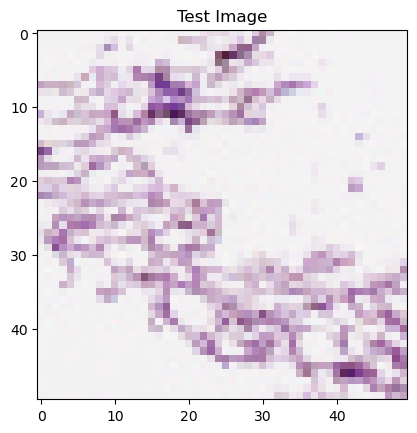

In [38]:
index2 = 402
img_plot(X_testRus, index2)

In [39]:
input2 = X_testRus[index2:index2+1]
print('Input Index =',index2)


Input Index = 402


In [40]:
label2 = Y_testRus[index2].argmax()
annpred2 = annmodel.predict(input2)[0].argmax()
base_cnnpred2 = base_cnnmodel.predict(input2)[0].argmax()
final_cnnpred2 = final_cnnmodel.predict(input2)[0].argmax()

print('Predicted Value using ann model',annpred2)
print('Predicted Value using base cnn model',base_cnnpred2)
print('Predicted Value using final cnn model',final_cnnpred2)
print("\nTrue Value",label2)

1/1 [==============================] - 0s 47ms/step
Predicted Value using ann model 0
Predicted Value using base cnn model 0
Predicted Value using final cnn model 0

True Value 0
